<a href="https://colab.research.google.com/github/sahil25mim10032/QR-detection-model/blob/main/QR_Code_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pip install tensorflow numpy opencv-python matplotlib python-barcode qrcode[pil] pillow

In [ ]:
pip install tensorflow numpy opencv-python matplotlib python-barcode qrcode[pil] pillow

In [ ]:
import os
import numpy as np
import qrcode
from barcode import EAN13
from barcode.writer import ImageWriter
import random
from PIL import Image

# Configuration
DATA_DIR = "barcode_dataset"
CLASSES = ["qr_code", "barcode"]
IMG_COUNT = 500  # Images per class

# Create directories
for c in CLASSES:
    os.makedirs(os.path.join(DATA_DIR, c), exist_ok=True)

print("Generating Synthetic Dataset...")

# 1. Generate QR Codes
for i in range(IMG_COUNT):
    data = f"https://example.com/{random.randint(1000,9999)}"
    qr = qrcode.make(data)
    qr = qr.resize((224, 224)) # Resize to standard AI input size
    qr.save(os.path.join(DATA_DIR, "qr_code", f"qr_{i}.png"))

# 2. Generate Barcodes (EAN-13)
writer = ImageWriter()
for i in range(IMG_COUNT):
    # specific random 12-digit number
    num = ''.join([str(random.randint(0, 9)) for _ in range(12)])
    my_code = EAN13(num, writer=writer)
    filename = os.path.join(DATA_DIR, "barcode", f"bar_{i}")
    my_code.save(filename)

    # Resize barcode to match QR code dimensions (224x224) for the AI
    img_path = filename + ".png"
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img.save(img_path)

print(f"Dataset generated at: {os.path.abspath(DATA_DIR)}")

Generating Synthetic Dataset...
Dataset generated at: /content/barcode_dataset


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
DATA_DIR = "barcode_dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- LOAD DATA ---
# We use image_dataset_from_directory which handles loading and splitting automatically
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Optimize loading speed
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# --- BUILD MODEL (Transfer Learning) ---
# 1. Base Model: MobileNetV2 (Pre-trained on ImageNet)
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False # Freeze base to keep pre-trained knowledge

# 2. Add our custom classification head
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)), # Normalize pixel values
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2), # Prevents overfitting
    layers.Dense(2, activation='softmax') # 2 classes: QR vs Barcode
])

# --- COMPILE & TRAIN ---
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Starting Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5 # 5 Epochs is usually enough for >95% on this simple task
)

# --- SAVE THE MODEL ---
model.save('barcode_verifier_model.h5')
print("Model saved as barcode_verifier_model.h5")

# --- PLOT RESULTS ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(f"Final Validation Accuracy: {val_acc[-1]*100:.2f}%")

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Starting Training...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 1.0000 - loss: 0.1120 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 9.2697e-04
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 7.0808e-04
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 1.0000 - loss: 9.1264e-04 - val_accuracy: 1.0000 - val_loss: 5.8067e-04
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 1.0000 - loss: 7.7602e-04 - val_accuracy: 1.0000 - val_loss: 4.8390e-04


Model saved as barcode_verifier_model.h5
Final Validation Accuracy: 100.00%


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model('barcode_verifier_model.h5')
class_names = ['barcode', 'qr_code'] # Based on folder names

def verify_barcode(img_path):
    # 1. Load and Resize Image
    img = image.load_img(img_path, target_size=(224, 224))

    # 2. Convert to Array and Batch
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    # 3. Predict
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # 4. Output Result
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    print(f"Image: {img_path}")
    print(f"Prediction: {predicted_class.upper()}")
    print(f"Confidence: {confidence:.2f}%")
    print("-" * 30)

# --- RUN TEST ---
# Generate a quick test image to verify
import qrcode
test_img_name = "test_verification.png"
qrcode.make("Test Data").save(test_img_name)

verify_barcode(test_img_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: test_verification.png
Prediction: QR_CODE
Confidence: 73.10%
------------------------------


In [ ]:
pip install tensorflow numpy opencv-python matplotlib python-barcode qrcode[pil] pillow

In [ ]:
import os
import numpy as np
import qrcode
from barcode import EAN13
from barcode.writer import ImageWriter
import random
from PIL import Image

# Configuration
DATA_DIR = "barcode_dataset"
CLASSES = ["qr_code", "barcode"]
IMG_COUNT = 500  # Images per class

# Create directories
for c in CLASSES:
    os.makedirs(os.path.join(DATA_DIR, c), exist_ok=True)

print("Generating Synthetic Dataset...")

# 1. Generate QR Codes
for i in range(IMG_COUNT):
    data = f"https://example.com/{random.randint(1000,9999)}"
    qr = qrcode.make(data)
    qr = qr.resize((224, 224)) # Resize to standard AI input size
    qr.save(os.path.join(DATA_DIR, "qr_code", f"qr_{i}.png"))

# 2. Generate Barcodes (EAN-13)
writer = ImageWriter()
for i in range(IMG_COUNT):
    # specific random 12-digit number
    num = ''.join([str(random.randint(0, 9)) for _ in range(12)])
    my_code = EAN13(num, writer=writer)
    filename = os.path.join(DATA_DIR, "barcode", f"bar_{i}")
    my_code.save(filename)

    # Resize barcode to match QR code dimensions (224x224) for the AI
    img_path = filename + ".png"
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img.save(img_path)

print(f"Dataset generated at: {os.path.abspath(DATA_DIR)}")

Generating Synthetic Dataset...
Dataset generated at: /content/barcode_dataset


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
DATA_DIR = "barcode_dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- LOAD DATA ---
# We use image_dataset_from_directory which handles loading and splitting automatically
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Optimize loading speed
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# --- BUILD MODEL (Transfer Learning) ---
# 1. Base Model: MobileNetV2 (Pre-trained on ImageNet)
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False # Freeze base to keep pre-trained knowledge

# 2. Add our custom classification head
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)), # Normalize pixel values
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2), # Prevents overfitting
    layers.Dense(2, activation='softmax') # 2 classes: QR vs Barcode
])

# --- COMPILE & TRAIN ---
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Starting Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5 # 5 Epochs is usually enough for >95% on this simple task
)

# --- SAVE THE MODEL ---
model.save('barcode_verifier_model.h5')
print("Model saved as barcode_verifier_model.h5")

# --- PLOT RESULTS ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(f"Final Validation Accuracy: {val_acc[-1]*100:.2f}%")

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.
Starting Training...
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9093 - loss: 0.2692 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 9.4235e-04


Model saved as barcode_verifier_model.h5
Final Validation Accuracy: 100.00%


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model('barcode_verifier_model.h5')
class_names = ['barcode', 'qr_code'] # Based on folder names

def verify_barcode(img_path):
    # 1. Load and Resize Image
    img = image.load_img(img_path, target_size=(224, 224))

    # 2. Convert to Array and Batch
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    # 3. Predict
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # 4. Output Result
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    print(f"Image: {img_path}")
    print(f"Prediction: {predicted_class.upper()}")
    print(f"Confidence: {confidence:.2f}%")
    print("-" * 30)

# --- RUN TEST ---
# Generate a quick test image to verify
import qrcode
test_img_name = "test_verification.png"
qrcode.make("Test Data").save(test_img_name)

verify_barcode(test_img_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: test_verification.png
Prediction: QR_CODE
Confidence: 73.09%
------------------------------


Found 1000 files belonging to 2 classes.
Using 200 files for validation.
Processing batch...

--- Final True Accuracy Report ---
              precision    recall  f1-score   support

     barcode       1.00      1.00      1.00       113
     qr_code       1.00      1.00      1.00        87

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



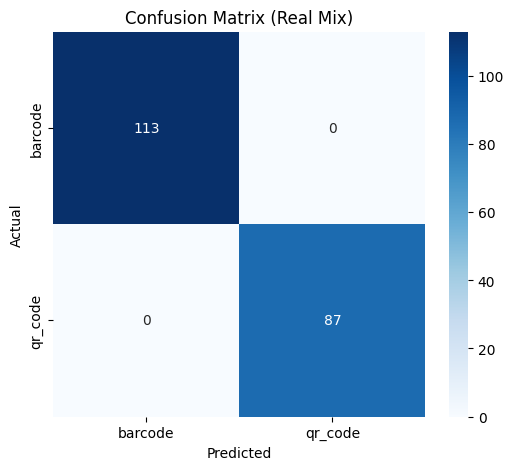

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data CORRECTLY (With Shuffle=True to get both classes)
val_ds_clean = tf.keras.utils.image_dataset_from_directory(
    "barcode_dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,              # MUST match the seed used in training
    image_size=(224, 224),
    batch_size=32,
    shuffle=True           # Changed to True so we get a mix of data
)

# 2. Get Predictions & Labels safely
y_true_all = []
y_pred_all = []

print("Processing batch...")
# We loop through the dataset manually to ensure images and labels stay paired
for images, labels in val_ds_clean:
    # Predict specifically on this batch of images
    preds = model.predict(images, verbose=0)

    # Save the actual labels and the predicted labels
    y_true_all.extend(labels.numpy())
    y_pred_all.extend(np.argmax(preds, axis=1))

# 3. Generate Report
class_names = val_ds_clean.class_names
print("\n--- Final True Accuracy Report ---")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

# 4. Plot Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Real Mix)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
DATA_DIR = "barcode_dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- LOAD DATA ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="training", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, validation_split=0.2, subset="validation", seed=123,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

# Optimize loading
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# --- DATA AUGMENTATION ---
# This helps the model generalize better
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

# --- BUILD MODEL (With Fine-Tuning) ---
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')

# UNFREEZE the base model to adapt it to barcodes
base_model.trainable = True
# Freeze the earlier layers (general features) and only train the last 50 layers (specific features)
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    data_augmentation,           # Add augmentation here
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

# Use a smaller learning rate for fine-tuning to avoid destroying pre-trained weights
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Starting Training with Fine-Tuning...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # Increased epochs for fine-tuning
)

model.save('barcode_verifier_model_v2.h5')
print("High-accuracy model saved.")

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.
Starting Training with Fine-Tuning...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.7338 - loss: 0.4988 - val_accuracy: 1.0000 - val_loss: 0.2089
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9983 - loss: 0.0824 - val_accuracy: 1.0000 - val_loss: 0.1459
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 1.0000 - loss: 0.0309 - val_accuracy: 1.0000 - val_loss: 0.1139
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.0944
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 0.0817
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 1.0000 - val_loss: 0.0701
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 

High-accuracy model saved.


In [ ]:
# Install system dependencies for barcode reading
!sudo apt-get install libzbar0
!pip install pyzbar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libdjvulibre-text libdjvulibre21 libfftw3-double3
  libgs9 libgs9-common libidn12 libijs-0.35 libilmbase25 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libopenexr25 libv4l-0
  libv4lconvert0 libwmflite-0.2-7 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x libfftw3-bin libfftw3-dev inkscape poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common libdjvulibre-t

Upload a REAL photo of a barcode or QR code:


Saving qr-6865526_1280.png to qr-6865526_1280.png

🔍 AI Diagnosis: BARCODE (99.31% confidence)
✅ VERIFIED! Content: https://pixabay.com/users/thedigitalartist-202249/


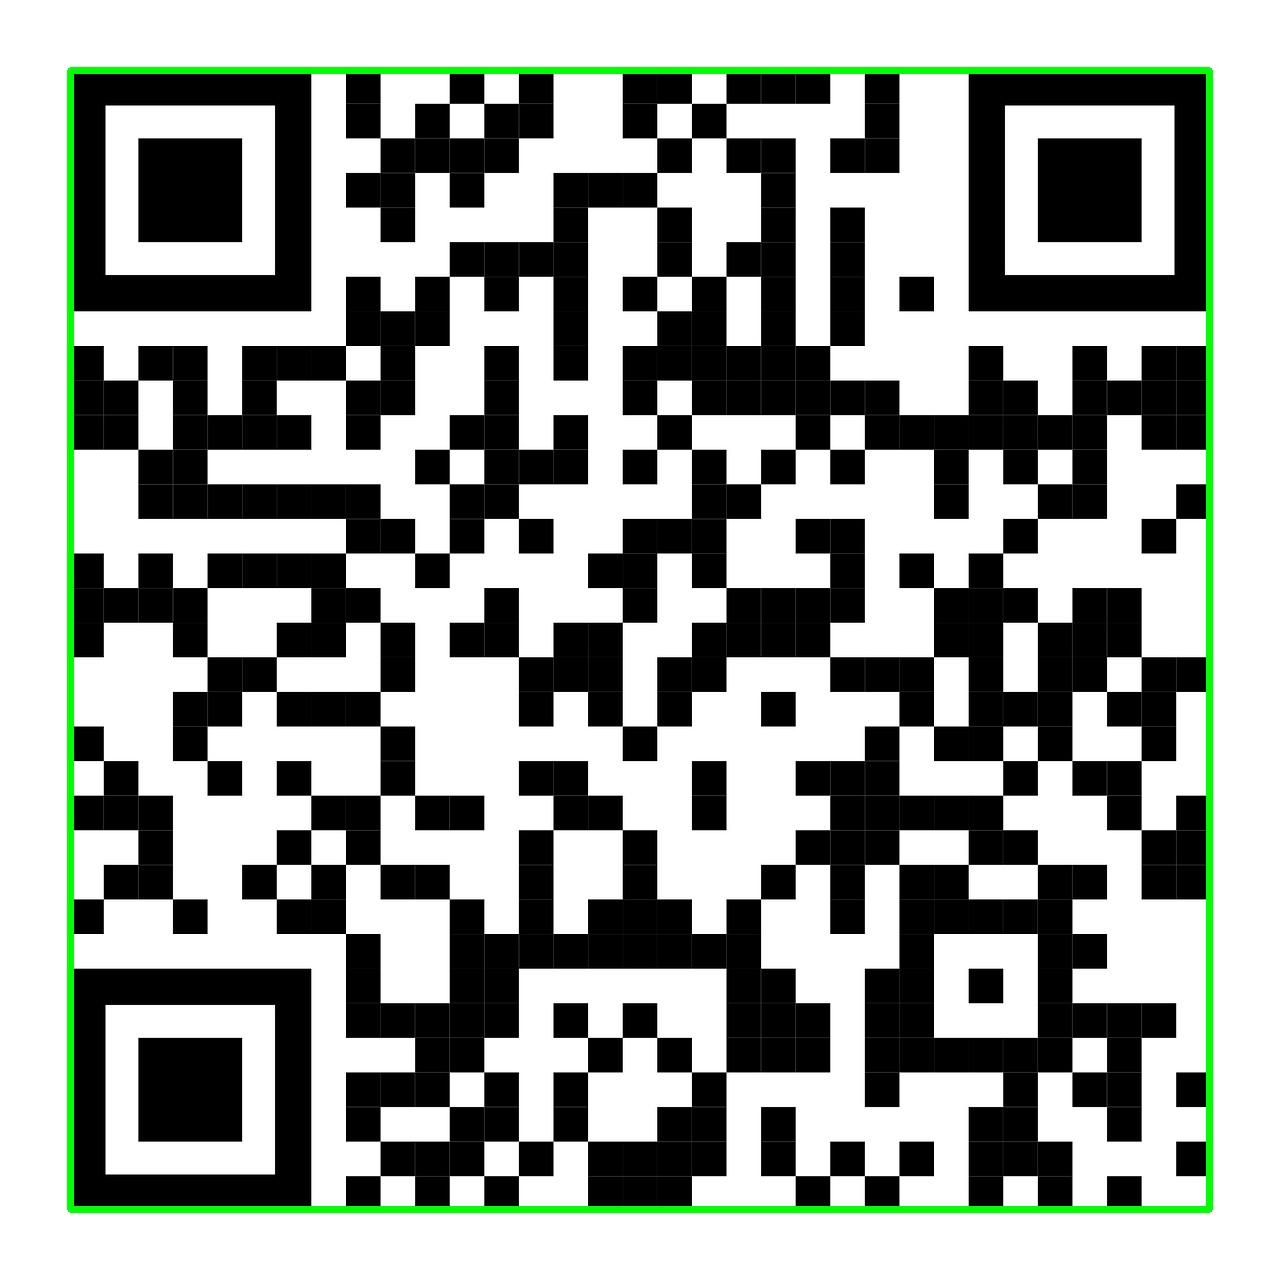

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from pyzbar.pyzbar import decode
from google.colab import files
from IPython.display import Image, display

# 1. Load your trained model
model = tf.keras.models.load_model('barcode_verifier_model_v2.h5')
class_names = ['barcode', 'qr_code']

def run_verification_system(img_path):
    # --- A. AI CLASSIFICATION ---
    # Load image for the AI (Resize to 224x224)
    img = cv2.imread(img_path)
    ai_input = cv2.resize(img, (224, 224))
    ai_input = np.expand_dims(ai_input, axis=0) / 255.0 # Normalize

    # Predict
    pred = model.predict(ai_input, verbose=0)
    predicted_type = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100

    print(f"\n🔍 AI Diagnosis: {predicted_type.upper()} ({confidence:.2f}% confidence)")

    # --- B. CONTENT VERIFICATION (READING DATA) ---
    # Convert to grayscale for better decoding
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    decoded_objects = decode(gray)

    if not decoded_objects:
        print("❌ VERIFICATION FAILED: Image is clear, but data is unreadable.")
    else:
        for obj in decoded_objects:
            data = obj.data.decode('utf-8')
            cv2.rectangle(img, (obj.rect.left, obj.rect.top),
                          (obj.rect.left + obj.rect.width, obj.rect.top + obj.rect.height),
                          (0, 255, 0), 5)
            print(f"✅ VERIFIED! Content: {data}")

    # --- C. SHOW RESULT ---
    output_path = "verified_result.jpg"
    cv2.imwrite(output_path, img)
    display(Image(output_path, width=400))

# --- RUN THE SYSTEM ---
print("Upload a REAL photo of a barcode or QR code:")
uploaded = files.upload()

for filename in uploaded.keys():
    run_verification_system(filename)